# LeNet Implementation!

1. Create a LeNet Model
2. Feed in the Augmented data
3. Finalize!

### Import the necessary packages

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import skimage
from sklearn.model_selection import train_test_split
import string

import imghdr
from PIL import Image
from os import listdir


### Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Right now, this model is based on input size of 32 x 32. Must adjust kernels + padding + strides
# if we want to use a different input size
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Data handling

In [61]:
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels


def process_data(imgs, labels, batch_size=4, channels=3, resize=15, crop_size=32, test_split=0.2):
  
  ## First, we preprocess the image, essentially resizing and cropping.
  transforms_array = applyTransforms(imgs, channels, crop_size, resize=resize)
  train_data, test_data, train_labels, test_labels = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)
  [trainloader, testloader] = train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size)
  return [trainloader, testloader]

# Reshape and Resize images
def applyTransforms(imgs, channels, crop_size, resize=15):
  # Define the necessary preprocessing transforms
  num_imgs = len(imgs)
  preprocess = transforms.Compose([
    transforms.Resize(resize), # Hyperparameter
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  ## Second, we must create the training and testing data. Format it so it's same as using CIFAR dataset
  transforms_array = np.zeros((num_imgs, channels, crop_size, crop_size))
  for i in range(num_imgs):
    temp = preprocess(imgs[i])
    transforms_array[i,:,:,:] = temp
  
  return transforms_array

  
def train_test_loaders(train_data, train_labels, test_data, test_labels, batch_size):
  ## Create the training dataand trainloader
  train_data_and_labels = []
  for i in range(len(train_data)):
    sample = (torch.Tensor(train_data[i,:,:,:]), train_labels[i])
    train_data_and_labels.append(sample)

  trainloader = torch.utils.data.DataLoader(train_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  ## Create the testing data and testloader
  test_data_and_labels = []
  for i in range(len(test_data)):
    sample = (torch.Tensor(test_data[i,:,:,:]), test_labels[i])
    test_data_and_labels.append(sample)

  testloader = torch.utils.data.DataLoader(test_data_and_labels, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  return [trainloader, testloader]

def imshow(img):
  # Unnormalize the image before showing!
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                  ])
    img = invTrans(img)
    print(img.shape)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


In [62]:
def train_model(trainloader, criterion, optimizer, model, n=20):
  for epoch in range(n):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 20 == 19:    # print every 200 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
              running_loss = 0.0

  print('Finished Training')
  return model


def test_model(testloader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

    return correct, total

def show_true_vs_predicted(testloader, classes, model):
    # print images
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))

# Model Training: Data without Augmentation

In [63]:
lenet_no_aug = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_no_aug.parameters(), lr=0.001, momentum=0.9)

path = "./Data_full/"

imgs, labels = loadImages(path)

[trainloader, testloader] = process_data(imgs, labels, crop_size=32)


torch.Size([3, 36, 138])


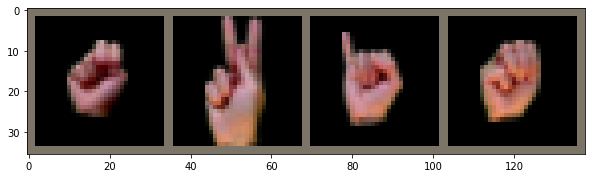

labels: N     K     I     M    


In [64]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [65]:
train_model(trainloader, criterion, optimizer, lenet_no_aug)

[1,    20] loss: 3.261
[1,    40] loss: 3.265
[1,    60] loss: 3.248
[1,    80] loss: 3.240
[1,   100] loss: 3.249
[1,   120] loss: 3.266
[2,    20] loss: 3.247
[2,    40] loss: 3.257
[2,    60] loss: 3.237
[2,    80] loss: 3.221
[2,   100] loss: 3.210
[2,   120] loss: 3.230
[3,    20] loss: 3.185
[3,    40] loss: 3.166
[3,    60] loss: 3.172
[3,    80] loss: 3.119
[3,   100] loss: 3.103
[3,   120] loss: 3.017
[4,    20] loss: 2.877
[4,    40] loss: 2.613
[4,    60] loss: 2.666
[4,    80] loss: 2.455
[4,   100] loss: 2.340
[4,   120] loss: 1.954
[5,    20] loss: 1.834
[5,    40] loss: 1.558
[5,    60] loss: 1.537
[5,    80] loss: 1.412
[5,   100] loss: 1.140
[5,   120] loss: 1.086
[6,    20] loss: 0.863
[6,    40] loss: 0.765
[6,    60] loss: 1.191
[6,    80] loss: 1.078
[6,   100] loss: 0.767
[6,   120] loss: 0.704
[7,    20] loss: 0.626
[7,    40] loss: 0.561
[7,    60] loss: 0.666
[7,    80] loss: 0.518
[7,   100] loss: 0.677
[7,   120] loss: 0.498
[8,    20] loss: 0.461
[8,    40] 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)

In [66]:
test_model(testloader, lenet_no_aug)

Accuracy of the network on the 130 test images: 100 %


(130, 130)

torch.Size([3, 36, 138])


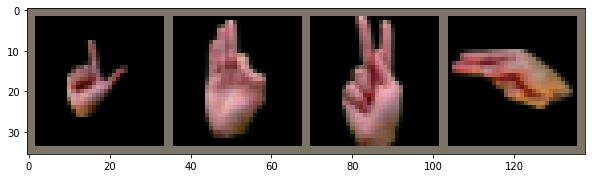

GroundTruth:  L     F     K     H    
Predicted:  L     F     K     H    


In [67]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(testloader, classes, lenet_no_aug)

## Part 2: Apply on Data Augmentation Set

torch.Size([3, 36, 138])


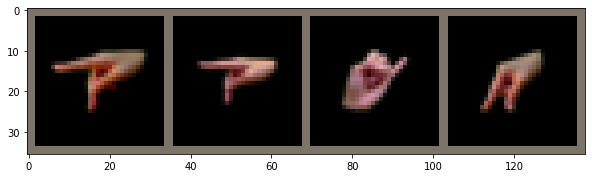

labels: P     P     J     Q    


In [68]:
lenet_with_aug = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet_with_aug.parameters(), lr=0.001, momentum=0.9)

path = "./FinalImages/"
imgs, labels = loadImages(path)

[trainloader, testloader] = process_data(imgs, labels, batch_size=4, channels=3, resize=30, crop_size=32, test_split=0.2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [69]:
train_model(trainloader, criterion, optimizer, lenet_with_aug)

[1,    20] loss: 3.269
[1,    40] loss: 3.253
[1,    60] loss: 3.271
[1,    80] loss: 3.257
[1,   100] loss: 3.265
[1,   120] loss: 3.260
[1,   140] loss: 3.260
[1,   160] loss: 3.264
[1,   180] loss: 3.255
[1,   200] loss: 3.251
[1,   220] loss: 3.259
[1,   240] loss: 3.257
[1,   260] loss: 3.251
[1,   280] loss: 3.258
[1,   300] loss: 3.251
[1,   320] loss: 3.256
[1,   340] loss: 3.253
[1,   360] loss: 3.254
[1,   380] loss: 3.261
[1,   400] loss: 3.252
[1,   420] loss: 3.254
[1,   440] loss: 3.254
[1,   460] loss: 3.250
[1,   480] loss: 3.246
[1,   500] loss: 3.255
[1,   520] loss: 3.244
[1,   540] loss: 3.261
[1,   560] loss: 3.248
[1,   580] loss: 3.246
[1,   600] loss: 3.245
[1,   620] loss: 3.250
[1,   640] loss: 3.248
[1,   660] loss: 3.252
[1,   680] loss: 3.252
[1,   700] loss: 3.252
[1,   720] loss: 3.236
[1,   740] loss: 3.233
[1,   760] loss: 3.233
[1,   780] loss: 3.224
[2,    20] loss: 3.219
[2,    40] loss: 3.224
[2,    60] loss: 3.210
[2,    80] loss: 3.203
[2,   100] 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)

In [72]:
test_model(testloader, lenet_with_aug)

Accuracy of the network on the 780 test images: 86 %


(673, 780)

torch.Size([3, 36, 138])


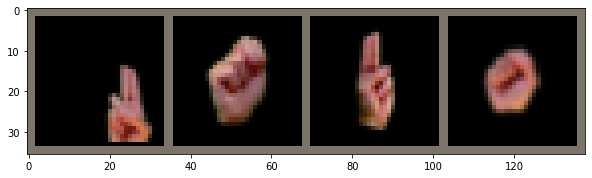

GroundTruth:  U     N     U     S    
Predicted:  U     N     U     S    


In [73]:
classes = list(string.ascii_uppercase)
show_true_vs_predicted(testloader, classes, lenet_with_aug)